# Майнор по Анализу Данных, Группа ИАД-2
## Домашнее задание №2: Классификация текстовых данных

**Общая информация**

**Срок сдачи:** 19 апреля 2017, 23:59

При отправлении ДЗ на почту `hse.minor.dm+2@gmail.com` указывайте фамилию в названии файла, а тему письма оформляйте в следующем виде:<br\>
** [ИАД-2] *{Фамилия}* *{Имя}* ДЗ*{Номер}* **

Сопровождайте ваш код изображеними, комментариями и выводами. <br\>
Иммейте ввиду, что на некоторые задачи нет единственного верного и полного ответа. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше.

Используйте данный Ipython Notebook при оформлении домашнего задания.

**По каким-то причинам, вариант меняется время от времени. Изначально выпал 2, потом 1, поэтому для работы используются оба варианта, в зависимости от того, какой выпадет.**

In [1]:
surname = "Пчелкин"
variant = hash(surname.lower())%2 + 1
print(f"Ваш вариант - {variant}")

Ваш вариант - 2


### Варианты

1. Набор SMS сообщений (sms) - **спам/не спам** - [источник](https://archive.ics.uci.edu/ml/datasets) - файл c данными: **data/SMSSpamCollection**
2. Набор рецензий на фильмы (reviews) - **positive/negative** - [источник](http://www.cs.cornell.edu/people/pabo/movie-review-data/) - файл c данными: **data/reviews.tsv**

**[Скачать данные](https://cloud.mail.ru/public/3AyQ/Pupnvo2dX)**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (10,6)
plt.rc('font', family='Arial')

Фиксация инициализирующего значения генератора случайных чисел. Оба были заданы составителем.

*для вывода дополнительных данных, изменить параметр `DETAILED_OUTPUT` на `True`.*

In [3]:
RANDOM_SEED = 12345  # for log regression
RANDOM_STATE = 123

NTIMES = 100  # amount of iterations for timeit
DETAILED_OUTPUT = False

if NTIMES < 1:
    raise ValueError("Wrong amount of iterations")

**При сохранении документа не известно почему могут пропасть графики. В этом случае, требуется заново выполнить весь код. Используемая версия python: 3.6.**

## Задача 1
#### Классификация текстовых сообщений (2 балла)

1. Загрузите исходные данные
2. Разбейте загруженные данные на обучающее (train) и тестовое подможества (test)
3. Переведите текстовые данные в векторный вид. Для этого воcпользуйтесь средствами sklearn для конвертации текста в векторы TF-IDF (настроить на обучающем подмножестве, n-gram=1, слова в нижний регистр)
4. Постройте на обучающем подмножестве следующие модели классификации:
    * K-ближайших соседей ($n=5$)
    * Логистическая регрессия ($C=1$)
    * Мультиномиальный наивный Байес ($\alpha=1$) 
5. Определите качество классификации (по доле правильных классификаций) на тестовом подмножестве
6. Определите с помощью timeit время обучения и предсказания (на тестовом подмножестве) 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer  # to transform text into Bag of Words
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score  # quality metrics
from sklearn import model_selection
from timeit import timeit

###### 1. Загрузка исходных данных.
В зависимости от выпавшего варианта.

In [5]:
if variant == 1:
    df = pd.read_csv(r"data/SMSSpamCollection", sep='\t', names=["class", "comment"])
else:
    df = pd.read_csv(r"data/reviews.tsv", sep='\t', names=["class", "comment"])
df.head()

class                                            comment
0      0  unless bob crane is someone of particular inte...
1      1  finds a way to tell a simple story , perhaps t...
2      0                   ill-considered , unholy hokum . 
3      0  nijinsky says , 'i know how to suffer' and if ...
4      1  the auteur's ear for the way fears and slights...

###### 2. Разбиение данных на подмножества (обучающее, тестовое). 
Размер тестовой выборки 0,3.

In [6]:
# transform into np.arrays
X = df.loc[:, 'comment']
y = df.loc[:, 'class']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(f"Shapes:\ttrain: {X_train.shape[0]}, test: {X_test.shape[0]}")

Shapes:	train: 7463, test: 3199


###### 3. Преобразование текстовых данных в векторный вид.
*Здесь и далее: параметры, заданные по умолчанию, не задаются явно.*

Преобразование всего набора данных в векторный вид сделано для применения разбиения с помощью `KFold`.

In [7]:
# lowercase=True and ngram_range=(1,1) by default
vectorizer = TfidfVectorizer()  # need to be more configured?
# get bugs of words
X_train_bow = vectorizer.fit_transform(X_train)  # learn vocabulary and transform into matrix
X_test_bow = vectorizer.transform(X_test)  # use vocabulary form train set
X_bow = vectorizer.fit_transform(X)  # for usage in KFold

if DETAILED_OUTPUT:
    vectorizer
    X_train_bow  # recieved shape is equal to original
    X_test_bow
    X_bow

Создание функции, определяющей показатели (временные, accuracy) каждой предложенной модели.

In [8]:
def benchmark(model, X_train, y_train, X_test, y_test, n_times=NTIMES, plot=True):
    model.fit(X_train, y_train)
    mean_train_t = timeit("model.fit(X_train, y_train)", globals=locals(), number=n_times)/n_times

    y_hat = model.predict(X_test)
    mean_test_t = timeit("model.predict(X_test)", globals=locals(), number=n_times)/n_times
        
    score = accuracy_score(y_hat, y_test)
    
    if plot:
        print(f"{'='*80}\n{model}\n{'accuracy:':<45} {score:5}")
        print(f"{'mean train time for {n_times} iterations:':<45} {mean_train_t:5}")
        print(f"{'mean test time for {n_times} iterations:':<45} {mean_test_t:5}")
    
    return {
        'accuracy': score,
        'train time': mean_train_t,
        'test time': mean_test_t
    }

Задание параметров моделей и самих моделей.

In [9]:
models_params = {
    'log_reg': {
        'solver': "lbfgs",
        'random_state': RANDOM_SEED
    }
}
models = {
    'knn': KNeighborsClassifier(),
    # penalty="l2", fit_intercept=True, max_iter=100, C=1 - are used by default
    'log_reg': LogisticRegression(**models_params['log_reg']),
    'bayes': MultinomialNB()
}

###### 4-6. Построение моделей и оценка качества их работы.

In [10]:
for model_type in models:
    _ = benchmark(models[model_type], X_train_bow, y_train, X_test_bow, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
accuracy:                                     0.710847139731166
mean train time for {n_times} iterations:     0.0010147653233848718
mean test time for {n_times} iterations:      0.9270336573083391
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=12345, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
accuracy:                                     0.7636761487964989
mean train time for {n_times} iterations:     0.23439726793622456
mean test time for {n_times} iterations:      0.00021620713189747674
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
accuracy:                                     0.7821194123163488
mean train time for {n_times} iterations:     0.00347

## Задача 2.
#### Применение k-folds (3 балла)

    Повторите решение задачи 1, но с ипользованием k-folds (k=4) для разделения исходных данных, обучения и тестирования.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from time import time

Создание счетчика очков по accuracy.

Создание KFold разбиения с перемешиванием и заданным ядром генератора случайных чисел.

In [12]:
scorer = make_scorer(score_func=accuracy_score, greater_is_better=False)  # which value of greater_is_better should be used?
kf = KFold(n_splits=4, random_state=RANDOM_STATE, shuffle=True)

Функции для определения показателей (временные, accuracy) каждой предложенной модели.
* `cross_val_benchmark` - с использованием функции `cross_val_score()`.
* `cv_benchmark` - ручное выполнение.

In [13]:
def cross_val_benchmark(model, X_train, y_train, kf, scorer, plot=True):
    t0 = time()
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=scorer)
    cross_val_t = time() - t0
    
    if plot:
        print(f"{'='*80}\n{model}")
        print(f"{'cross val scores (accuracy):':<45} {-scores}")
        print(f"{'cross val time:':<45}{cross_val_t:5}")
    
    return {
        'accuracy': scores,
        'cross val time': cross_val_t,
    }

def cv_benchmark(model, X, y, X_all, y_all, kf, scoring, n_times=1, plot=False):
    scores = []
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X_all[train_idx], X_all[test_idx]
        y_train, y_test = y_all[train_idx], y_all[test_idx]

        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        scores.append(scoring(y_test, y_hat))
    
    mean_train_t = timeit("model.fit(X_train, y_train)", globals=locals(), number=n_times)/n_times
    mean_test_t = timeit("model.predict(X_test)", globals=locals(), number=n_times)/n_times
    
    if plot:
        print(f"{'='*80}\n{model}\n{'scores:':<45} {scores}")
        print(f"{f'mean train time for {n_times} iterations:':<45} {mean_train_t:5}")
        print(f"{f'mean test time for {n_times} iterations:':<45} {mean_test_t:5}")

    return {
        'scores': np.array(scores),
        'train time': mean_train_t,
        'test time': mean_test_t,
    }

Проверка с использованием `cross_val_score()` и вручную.

In [14]:
for model_type in models:
    _ = cross_val_benchmark(models[model_type], X_bow, y, kf, scorer)
    
print(f"\n\n{'HAND-MADE TEST':^80}\n\n")
for model_type in models:
    _ = cv_benchmark(models[model_type], X_bow, y, X_bow, y, kf, 
                     scoring=accuracy_score, n_times=NTIMES, plot=True)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
cross val scores (accuracy):                  [ 0.72130533  0.70105026  0.70168856  0.7043152 ]
cross val time:                              3.3262856006622314
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=12345, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
cross val scores (accuracy):                  [ 0.77156789  0.75656414  0.74709193  0.76322702]
cross val time:                              0.6584351062774658
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
cross val scores (accuracy):                  [ 0.79032258  0.76744186  0.77636023  0.78611632]
cross val time:                              0.062041282653808594


                               

При ручной проверке получены идентичные результаты.

## Задача 3.
#### Выбор модели (5 баллов)

Функция отображения полученных результатов (включая графики).

In [15]:
def display_results(scores, param, log=True, plot=True):
    mean_scores = []
    for i, idx in enumerate(scores):
        score = scores[idx]['scores']
        if plot:
            print(f"{i:<3}{float(idx):<10.5}:\t{score},\tmean: {score.mean():.5}")
        mean_scores.append(score.mean())
        plt.annotate(i, (param[i], mean_scores[i]))
    plt.plot(param, mean_scores, 'o-')
    plt.ylabel("accuracy")
    plt.xlabel("training params")
    plt.title("mean score")
    plt.grid()
    if log:
        plt.xscale('log')
    
    win_idx = np.argmax(mean_scores)
    win = param[win_idx]
    print(f"Best is: {float(win):.5}\t[idx: {win_idx}, value: {max(mean_scores)}]")
    return win

    1) Используя данные из задачи 1, разбейте обучающее подмножество (train) с использованием k-folds (k=4)
    2) Обучите и протестируйте на разбитом обучающем подмножестве классификаторы со следующими параметрами:

Зaдание параметров.

In [16]:
params_range = {
    'knn': np.arange(1, 150, 20),  # количество соседей
    'log_reg': np.logspace(-2, 10, 8, base=10),  # параметр регуляризации
    'bayes': np.logspace(-4, 1, 8, base=10)  # сглаживающий параметр
}

best_params = {}  # to store best results

* **K-ближайших соседей**

kf уже настроен (k=4).

**Сказано взять данные из первой задачи, обучающее подмножество (train), поэтому использован `X_train` а не `X`.**

Best is: 61.0	[idx: 3, value: 0.7384435460002472]


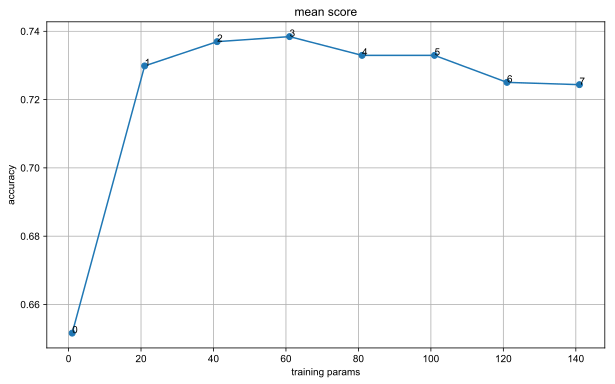

In [17]:
knn_scores = {}
for k in params_range['knn']:
    knn_scores[k] = cv_benchmark(KNeighborsClassifier(k), 
                                 X_train_bow, y_train, X_bow, y,
                                 kf, scoring=accuracy_score)
    
best_params['knn'] = display_results(knn_scores, params_range['knn'], log=False, plot=DETAILED_OUTPUT)

* **Логистическая регрессия**

Best is: 26.827	[idx: 2, value: 0.756532230488292]


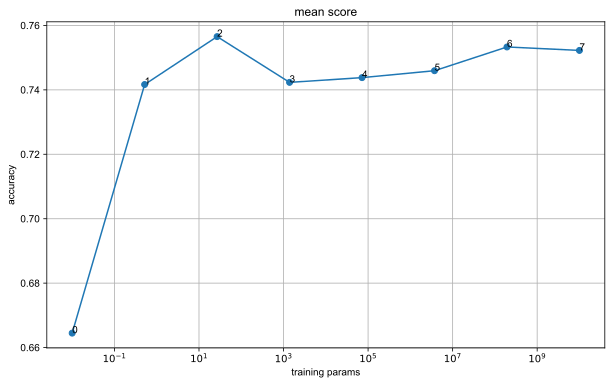

In [18]:
log_reg_scores = {}
for c in params_range['log_reg']:
    log_reg_scores[c] = cv_benchmark(LogisticRegression(C=c, **models_params['log_reg']), 
                                     X_train_bow, y_train, X_bow, y, kf, scoring=accuracy_score)

best_params['log_reg'] = display_results(log_reg_scores, params_range['log_reg'], plot=DETAILED_OUTPUT)

* **Мультиномиальный наивный Байес**

Best is: 1.9307	[idx: 6, value: 0.7672533612636455]


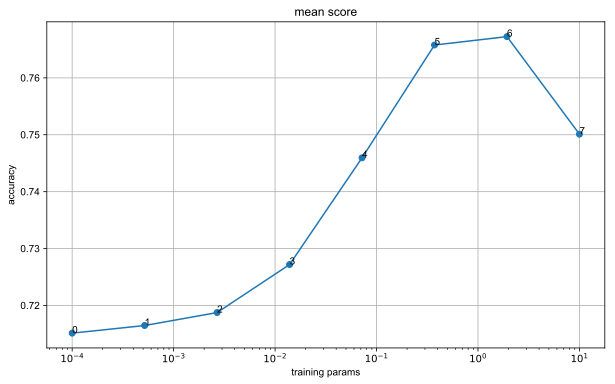

In [19]:
bayes_scores = {}
for alpha in params_range['bayes']:
    bayes_scores[alpha] = cv_benchmark(MultinomialNB(alpha=alpha), 
                                       X_train_bow, y_train, X_bow, y, kf, 
                                       scoring=accuracy_score)

best_params['bayes'] = display_results(bayes_scores, params_range['bayes'], plot=DETAILED_OUTPUT)

    3) Постройте графики (параметры модели)-(доля правильных классификаций) при обучении и валидации
    4) Выберите лучшую модель для каждого метода, используя значение качества классификации (использовать долю правильных классификаций)
    5) Выбранные модели обучите на обучающем подмножестве (train) и протестируйте на тестовом (test). Определите время обучения и предсказания (см. задачу 1 п. 6)
    6) Повторите шаги 2-4 для n-gram=2
    7) Выведите итоговые данные по всем методам для лучших моделей (метод, n-gram, значение параметра модели, время обучения, время предсказания, доля правильных классификаций)
    8) Сделайте выводы по полученным результатам (преимущества и недостатки методов)

Для выбора лучшей модели использовалось среднее значение accuracy, полученное при кросс-валидации.

###### Обучение выбранных лучших моделей.

In [20]:
best_models = {
    'knn': KNeighborsClassifier(n_neighbors=best_params['knn']),
    'log_reg': LogisticRegression(C=best_params['log_reg'], **models_params['log_reg']),
    'bayes': MultinomialNB(alpha=best_params['bayes'])
}

models_scores = {}
for model_type in best_models:
    models_scores[model_type] = benchmark(best_models[model_type], 
                                          X_train_bow, y_train, X_test_bow, y_test, 
                                          n_times=NTIMES)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=61, p=2,
           weights='uniform')
accuracy:                                     0.7542982181931853
mean train time for {n_times} iterations:     0.001497811372651654
mean test time for {n_times} iterations:      0.9787917819138474
LogisticRegression(C=26.826957952797247, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=12345,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
accuracy:                                     0.769302907158487
mean train time for {n_times} iterations:     0.37049694840860525
mean test time for {n_times} iterations:      0.00023964571434476056
MultinomialNB(alpha=1.9306977288832496, class_prior=None, fit_prior=True)
accuracy:                                     0.7783682400750235
mean train time for {n_

###### Формирование исходных данных для n-gram=2.
Имеет смысл переформировать только признаки объектов, не трогая ответы (они остаются теми же, а при разбиении на фолды будут используется то же ядро генератора случайных чисел).

In [21]:
X2_train, X2_test = model_selection.train_test_split(X, test_size=0.3, random_state=RANDOM_STATE)
vectorizer2 = TfidfVectorizer(ngram_range=(2,2))
X2_train_bow = vectorizer2.fit_transform(X2_train)
X2_test_bow = vectorizer2.transform(X2_test)
X2_bow = vectorizer2.fit_transform(X)

best_params2 = {}

if DETAILED_OUTPUT:
    print(f"{X2_train.shape[0]}, {X2_test.shape[0]}")
    vectorizer2
    X2_train_bow
    X2_test_bow
    X2_bow

###### Повторение шагов 2-4.

In [22]:
knn_scores2 = {}
for k in params_range['knn']:
    knn_scores2[k] = cv_benchmark(KNeighborsClassifier(k), 
                                  X2_train_bow, y_train, X2_bow, y,
                                  kf, scoring=accuracy_score)
    
best_params2['knn'] = display_results(knn_scores2, params_range['knn'], log=False, plot=DETAILED_OUTPUT)

Best is: 61.0	[idx: 3, value: 0.6415650169966869]


In [23]:
log_reg_scores2 = {}
for c in params_range['log_reg']:
    log_reg_scores2[c] = cv_benchmark(LogisticRegression(C=c, **models_params['log_reg']), 
                                      X2_train_bow, y_train, X2_bow, y, kf, scoring=accuracy_score)

best_params2['log_reg'] = display_results(log_reg_scores2, params_range['log_reg'], plot=DETAILED_OUTPUT)

Best is: 26.827	[idx: 2, value: 0.6903402641885699]


Best is: 0.37276	[idx: 5, value: 0.7015945708300648]


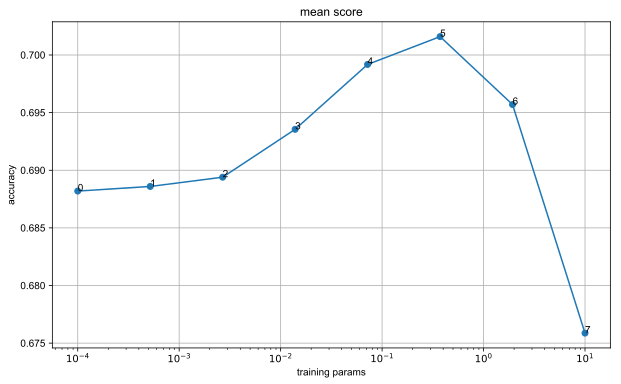

In [24]:
bayes_scores2 = {}
for alpha in params_range['bayes']:
    bayes_scores2[alpha] = cv_benchmark(MultinomialNB(alpha=alpha), 
                                        X2_train_bow, y_train, X2_bow, y, kf, 
                                        scoring=accuracy_score)

best_params2['bayes'] = display_results(bayes_scores2, params_range['bayes'], plot=DETAILED_OUTPUT)

In [25]:
best_models2 = {
    'knn': KNeighborsClassifier(n_neighbors=best_params2['knn']),
    'log_reg': LogisticRegression(C=best_params2['log_reg'], **models_params['log_reg']),
    'bayes': MultinomialNB(alpha=best_params2['bayes'])
}

models_scores2 = {}
for model_type in best_models2:
    models_scores2[model_type] = benchmark(best_models2[model_type], 
                                           X2_train_bow, y_train, X2_test_bow, y_test,
                                           n_times=NTIMES)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=61, p=2,
           weights='uniform')
accuracy:                                     0.6620819005939356
mean train time for {n_times} iterations:     0.001032336776636953
mean test time for {n_times} iterations:      0.397475496610578
LogisticRegression(C=26.826957952797247, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=12345,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
accuracy:                                     0.7077211628633948
mean train time for {n_times} iterations:     1.2271342409422987
mean test time for {n_times} iterations:      0.00022762921796129376
MultinomialNB(alpha=0.37275937203149417, class_prior=None, fit_prior=True)
accuracy:                                     0.7177242888402626
mean train time for {n_

###### Отображение результатов лучших полученных моделей.

In [26]:
for model in models:
    print(f"{'name':<13}\t{model}\n{'param':<13}\t{float(best_params[model]):.5}")
    print(f"{'n-gram':<13}\t1")
    for score in models_scores[model]:
        print(f"{score:<12}:\t{models_scores[model][score]:.5}")
    print()
    print(f"{'name':<13}\t{model}\n{'param':<13}\t{float(best_params2[model]):.5}")
    print(f"{'n-gram':<13}\t2")
    for score in models_scores2[model]:
        print(f"{score:<12}:\t{models_scores2[model][score]:.5}")
    print()

name         	knn
param        	61.0
n-gram       	1
accuracy    :	0.7543
train time  :	0.0014978
test time   :	0.97879

name         	knn
param        	61.0
n-gram       	2
accuracy    :	0.66208
train time  :	0.0010323
test time   :	0.39748

name         	log_reg
param        	26.827
n-gram       	1
accuracy    :	0.7693
train time  :	0.3705
test time   :	0.00023965

name         	log_reg
param        	26.827
n-gram       	2
accuracy    :	0.70772
train time  :	1.2271
test time   :	0.00022763

name         	bayes
param        	1.9307
n-gram       	1
accuracy    :	0.77837
train time  :	0.0032631
test time   :	0.00049876

name         	bayes
param        	0.37276
n-gram       	2
accuracy    :	0.71772
train time  :	0.0072276
test time   :	0.0011691



###### Выводы:
С точки зрения оценки по доле правильных ответов, лучше работают модели с n-gram=1.

По очевидным причинам (вычисление расстояния до каждого объекта), модель к-ближайших соседей работает очень медленно при предсказании, однако очень быстро обучается (просто запоминает входные данные). Из приведенных моделей с заданными параметрами обучения, этот метод также показывает самое низкое качество предсказаний (по accuracy).

Самым оптимальным по временам обучения и предсказания является наивный байес (время предсказания в линейной регресси меньше, однако время обучения очень велико). Также, на приведеных данных и заданых рамках выбора параметров, наивный байеский метод дает лучшее качество предсказаний.

###### Резюме:
1. knn:
  + быстрое обучение
  - низкая скорость предсказания
  - низкая точность предсказаний
2. lin_reg:
  + высокая скорость предсказаний
  + довольно высокая точность предсказаний
  - низкая скорость обучения
3. bayes:
  + высокая скорость предсказаний
  + высокая скорость обучения
  + довольно высокая точность предсказаний

## Задача 4. (опционально)
#### Исследование влияния количества признаков FeatureHasher на качество классификации (5 баллов к сумме по всем ДЗ) 

    Как будет меняться качество классификации для обозначенных ранее методов при использовании FeatureHasher (или HashingVectorizer) из пакета sklearn перед TF-IDF преобразованием, если

In [27]:
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [28]:
features_n = np.logspace(1, 5, 5, base=10, dtype=int) # количество признаков
grid_params = {
    'knn': {
        'model__n_neighbors': params_range['knn'],
        'hasher__n_features': features_n
    },
    'log_reg': {
        'model__C': params_range['log_reg'],
        'hasher__n_features': features_n
    },
    'bayes': {
        'model__alpha': params_range['bayes'],
        'hasher__n_features': features_n
    },
}
cv_scorer = make_scorer(accuracy_score)

    Можно воспользоваться GridSearchCV

Определение лучших параметров (среди заданных) по всем n_features. 

In [29]:
cv_logs = []
for model_type in grid_params:
    pipline = Pipeline([
        ('hasher', HashingVectorizer(non_negative=True)), 
        ('vectorizer', TfidfTransformer()), 
        ('model', models[model_type])
    ])
    cv_grid = GridSearchCV(
        estimator=pipline,
        param_grid=grid_params[model_type],
        scoring=cv_scorer, 
        cv=kf
    )
    res_grid = cv_grid.fit(X_train, y_train)
    cv_logs.append(res_grid.cv_results_)
    
    print(f"{'='*80}\n{'name:':<45} {model_type}\n{'best score:':<45} {res_grid.best_score_}")
    print(f"{'best time:':<45} {res_grid.cv_results_['mean_fit_time'][res_grid.best_index_]}")
    for param in res_grid.best_params_:
        print(f"{param:<45} {res_grid.best_params_[param]}")

name:                                         knn
best score:                                   0.7318772611550315
best time:                                    0.18712395429611206
hasher__n_features                            100000
model__n_neighbors                            81
name:                                         log_reg
best score:                                   0.7439367546563045
best time:                                    1.554628849029541
hasher__n_features                            100000
model__C                                      26.826957952797247
name:                                         bayes
best score:                                   0.755862253785341
best time:                                    0.18224596977233887
hasher__n_features                            100000
model__alpha                                  1.9306977288832496


Для просмотра всех результатов, требуется прочтение логов.

In [30]:
if DETAILED_OUTPUT:
    cv_logs

В среднем, с повышением количества признаков качество классификации возрастает.